# __THƯ VIỆN__

In [1]:
import pandas as pd
import numpy as np
import torch
import ast

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.model_selection import train_test_split

import string
import advertools as adv
import emoji
import regex as re
from underthesea import word_tokenize, pos_tag

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

import import_ipynb
import MLTunning as MLT

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# __DỮ LIỆU__

In [2]:
df_category = pd.read_excel('C:\\Users\\Nguyen_Thanh_Vinh\\Downloads\\train_category_split_vie.xlsx')
df_category = df_category.reset_index()
df_category = df_category.loc[:, ~df_category.columns.str.contains('^Unnamed')]
df_category.head(5)

,index,comment,category
0,0,Đã nhận được hàng,Đóng gói và giao hàng
1,1,cửa hàng đóng gói nhanh chóng,Đóng gói và giao hàng
2,2,màu sắc đúng,Đóng gói và giao hàng
3,3,mô hình đúng,Đóng gói và giao hàng
4,4,đúng kích thước,Đóng gói và giao hàng


# __VECTORIZE__

In [3]:
def preprocess_text(dataset, col_name, teencode_dict_path):
    # 1. Convert text to lowercase
    dataset[col_name] = dataset[col_name].str.lower()

    # 2. Load teencode dictionary
    teencode_dict = dict(pd.read_csv(teencode_dict_path, delimiter='\t').values)

    # 3. Handle teencode
    def handle_teencode(text, teencode_dict):
        return ' '.join([teencode_dict[word] if word in teencode_dict else word for word in text.split(' ')])

    dataset[col_name] = dataset[col_name].apply(lambda x: handle_teencode(str(x), teencode_dict))

    # 4. Standardize stretched words (e.g., "heeeellooo" -> "helo")
    dataset[col_name] = dataset[col_name].apply(lambda x: re.sub(r'(\D)\1+', r'\1', str(x)))

    # 5. Remove words with length greater than 7
    def remove_words_over_length(text, length):
        return ' '.join([word for word in text.split(' ') if len(word) <= length])

    dataset[col_name] = dataset[col_name].apply(lambda x: remove_words_over_length(str(x), 7))

    # 6. Remove white spaces, \n, \t, \r, \v
    dataset[col_name] = dataset[col_name].apply(lambda x: re.sub(r'\s+', ' ', str(x).strip()))

    # 7. Remove numbers and special characters
    def remove_numbers_and_special_characters(text):
        text = re.sub(r'[' + string.punctuation + ']', '', text)  # Remove special characters
        text = re.sub(r'\d+', '', text)  # Remove numbers
        return text

    dataset[col_name] = dataset[col_name].apply(lambda x: remove_numbers_and_special_characters(str(x)))

    #8. Drop NA data
    dataset.dropna(subset=[col_name], inplace=True)

    # 9. Tokenize text using word_tokenize from underthesea
    dataset['word_tokenize'] = dataset[col_name].apply(lambda x: word_tokenize(str(x), format='text'))

    return dataset

In [4]:
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        stopwords = set(line.strip() for line in f)
    return stopwords

In [5]:
STOPWORDS_FILE = "vietnamese-stopwords.txt"
stopwords_vietnamese = load_stopwords(STOPWORDS_FILE)

def process_tweet_vietnamese(tweet):

    # Tokenize bằng underthesea (tách từ)
    tweet_tokens = word_tokenize(tweet, format="text").split()

    # Làm sạch token
    tweets_clean = []
    for word in tweet_tokens:
        if word not in stopwords_vietnamese and word not in string.punctuation:
            tweets_clean.append(word.lower())  # Đưa về chữ thường

    return tweets_clean

In [6]:
import numpy as np

def build_freqs(tweets, ys):
    yslist = np.squeeze(ys).tolist()

    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet_vietnamese(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [7]:
df_category = preprocess_text(df_category, 'comment', 'C:\\Users\\Nguyen_Thanh_Vinh\\Downloads\\FEEDBACK-ANALYSIS-master\\teencode.txt')

In [8]:
label_check = []
label = []
dict_label = {}
category = df_category.loc[:, 'category']

for i in category:
    if i not in label_check:
        value = len(label_check)
        label_check.append(i)
        label.append(value)
        dict_label[i] = value
    else:
        label.append(dict_label[i])
labels = np.array(label)

In [9]:
tweets = df_category.loc[:, 'comment']

freqs = build_freqs(tweets, labels)

print(f'type(freqs) = {type(freqs)}')

print(f'len(freqs) = {len(freqs)}')

type(freqs) = <class 'dict'>
len(freqs) = 1365


In [ ]:
import json

# Chuyển đổi tuple keys thành string keys
freqs_str_keys = {str(k): v for k, v in freqs.items()}

# Góp dữ liệu vào dictionary
output_data = {
    "vocab": freqs_str_keys,
    "labels": labels
}

# Lưu dữ liệu vào file JSON
output_file = "vocab_and_labels.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(output_data, f, ensure_ascii=False, indent=4)

print(f"Data has been saved to {output_file}")

In [10]:
def freq_sentence_category(keys):
    data_freq = []

    for word in keys:
    
        dict_count = {}
        for col in label_check:
            dict_count[col] = 0
        
        for idx, i in enumerate(label_check):
            if (word, idx) in freqs:
                dict_count[i] = freqs[(word, idx)]
            
        list_temp = [word]
        list_temp.extend(dict_count.values())
        data_freq.append(list_temp)
    return data_freq

In [11]:
def create_data(df):
    temp = ['idx', 'bias'] + label_check + ['category']
    df_ = pd.DataFrame(columns = temp)
    for idx, tweet in enumerate(df_category.loc[:, 'comment']):
        list_freq = freq_sentence_category(process_tweet_vietnamese(tweet))

        dict_count = {}
        for col in label_check:
            dict_count[col] = 0
            
        for index, row in enumerate(list_freq):
            row = row[1:]
            for cate, value in zip(label_check, row):
                if(type(value) == str): continue
                dict_count[cate] += value

        new_row = { 'idx': idx, 'bias': 1 }
        for label in label_check:
            new_row[label] = dict_count[label]
        new_row['category'] = df.loc[idx, 'category']
        
        df_.loc[len(df_)] = new_row
    return df_

In [12]:
# Hình thành nên tập train
data_train = create_data(df_category)

# __RANDOMFOREST__

In [13]:
X = data_train.iloc[:, 1:-1]
y = labels

In [14]:
from sklearn.model_selection import train_test_split
X_train, x_val, y_train, val_y = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

def tune_random_forest(train_x, train_y, val_x, val_y):
    """
    Hiệu chỉnh hyperparameter cho RandomForestClassifier và đánh giá hiệu suất.

    Args:
        train_x: Dữ liệu huấn luyện.
        train_y: Nhãn của dữ liệu huấn luyện.
        val_x: Dữ liệu kiểm định.
        val_y: Nhãn của dữ liệu kiểm định.
    """

    # Define the parameter grid for RandomForestClassifier
    param_dist_rf = {
        'n_estimators': [50, 100, 200, 300, 500],  # Number of trees
        'max_depth': [None, 10, 20, 30, 40],  # Maximum depth of each tree
        'min_samples_split': [2, 5, 10, 20],  # Minimum samples required to split an internal node
        'min_samples_leaf': [1, 2, 4, 6],  # Minimum samples required to be at a leaf node
        'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
    }

    # Create a RandomForestClassifier model
    rf_model = RandomForestClassifier()

    # Perform RandomizedSearchCV to find the best hyperparameters
    random_search_rf = RandomizedSearchCV(
        rf_model, param_distributions=param_dist_rf, n_iter=5, cv=5, scoring='accuracy', random_state=42
    )
    random_search_rf.fit(train_x, train_y)

    # Print the best hyperparameters and score
    print("Best hyperparameters (RandomForestClassifier):", random_search_rf.best_params_)
    print("Best score (RandomForestClassifier):", random_search_rf.best_score_)

    # Evaluate the best model on the validation set
    best_rf_model = random_search_rf.best_estimator_
    predictions = best_rf_model.predict(val_x)

    # Print classification report
    print('Classification Report: ', 'RandomForestClassifier')
    print(classification_report(val_y, predictions))

    # Calculate and print ROC AUC score for multi-class
    probabilities = best_rf_model.predict_proba(val_x)  # Get predicted probabilities for each class
    auc = roc_auc_score(val_y, probabilities, multi_class="ovr")  # Use 'ovr' (one-vs-rest) for multi-class
    print('ROC_AUC_SCORE is ', auc)

    # Convert true labels to binary format (One-vs-Rest)
    val_y_bin = label_binarize(val_y, classes=np.unique(val_y))  # Binarize the true labels for multi-class ROC
    n_classes = val_y_bin.shape[1]  # Number of classes

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        false_position_rate, true_position_rate, _ = roc_curve(val_y_bin[:, i], probabilities[:, i])
        plt.plot(false_position_rate, true_position_rate, label=f'Class {i} (AUC = {roc_auc_score(val_y_bin[:, i], probabilities[:, i]):.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line (no discrimination)
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve for Multi-Class Classification')
    plt.legend(loc='lower right')
    plt.show()

    # Plot confusion matrix
    sns.heatmap(confusion_matrix(val_y, predictions), fmt='', annot=True)
    plt.show()

    # Result
    results = {
        'accuracy': accuracy_score(val_y, predictions),
        'precision': precision_score(val_y, predictions, average='macro'),
        'recall': recall_score(val_y, predictions, average='macro'),
        'auc': auc
    }

    return best_rf_model, results

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best hyperparameters (RandomForestClassifier): {'n_estimators': 50, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': False}
Best score (RandomForestClassifier): 0.9004711298124471
Classification Report:  RandomForestClassifier
              precision    recall  f1-score   support

           0       0.94      0.84      0.89       134
           1       0.91      0.84      0.88        38
           2       0.94      0.73      0.82        41
           3       0.80      0.75      0.77        16
           4       1.00      0.94      0.97        17
           5       0.93      0.96      0.94       301
           6       0.00      0.00      0.00         2
           7       0.83      0.93      0.88       167

    accuracy                           0.90       716
   macro avg       0.79      0.75      0.77       716
weighted avg       0.90      0.90      0.90       716

ROC_AUC_SCORE is  0.9791288095005759


c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

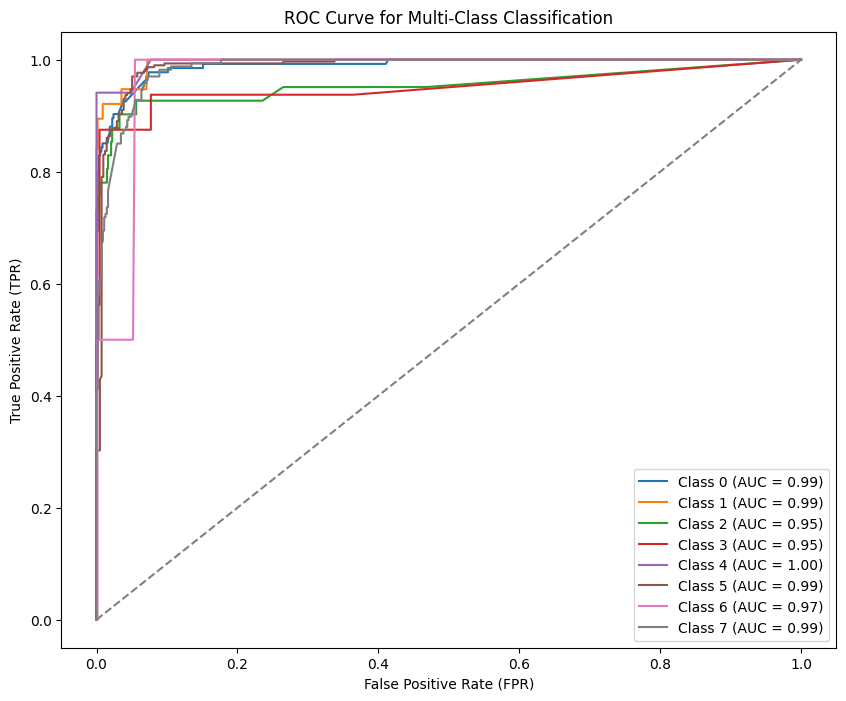

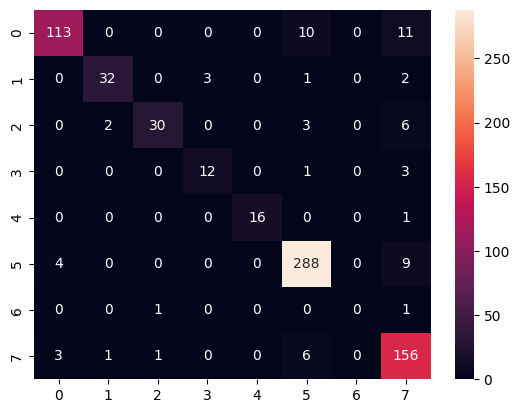

c:\Users\Nguyen_Thanh_Vinh\anaconda3\envs\RP_Env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
rf_results_split = tune_random_forest(X_train, y_train, x_val, val_y)